## IMPORTING LABRARIES

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Custom SVM class with non-linear kernel support
class SVM:
    def __init__(self, kernel="rbf", C=1.0, epsilon=0.1, degree=3, gamma=0.5, max_iter=1000, learning_rate=0.001):
        self.kernel = kernel
        self.C = C
        self.epsilon = epsilon
        self.degree = degree
        self.gamma = gamma
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.alpha = None  # Lagrange multipliers

    def _kernel(self, X1, X2):
        if self.kernel == "linear":
            return np.dot(X1, X2.T)
        elif self.kernel == "poly":
            return (np.dot(X1, X2.T) + 1) ** self.degree
        elif self.kernel == "rbf":
            if X1.ndim == 1 and X2.ndim == 1:
                return np.exp(-self.gamma * np.linalg.norm(X1 - X2) ** 2)
            elif X1.ndim > 1 and X2.ndim == 1:
                return np.exp(-self.gamma * np.linalg.norm(X1 - X2, axis=1) ** 2)
            elif X1.ndim == 1 and X2.ndim > 1:
                return np.exp(-self.gamma * np.linalg.norm(X1 - X2, axis=1) ** 2)
            elif X1.ndim > 1 and X2.ndim > 1:
                return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) ** 2)
        else:
            raise ValueError("Unsupported kernel")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)  # Lagrange multipliers for dual problem
        self.support_vectors = X
        self.support_labels = y

        # Gradient descent-based optimization (simple approach for illustration)
        for _ in range(self.max_iter):
            for i in range(n_samples):
                prediction = self._predict_single(X[i])
                error = y[i] - prediction

                if abs(error) > self.epsilon:
                    self.alpha[i] += self.learning_rate * error

    def _predict_single(self, x):
        kernel_values = self._kernel(self.support_vectors, x)
        return np.dot(self.alpha, kernel_values)

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def evaluate(self, X, y, regression=False):
        y_pred = self.predict(X)
        if regression:
            rmse = np.sqrt(np.mean((y - y_pred) ** 2))
            return rmse
        else:
            predictions = np.sign(y_pred)
            accuracy = np.mean(predictions == y)
            return accuracy


In [ ]:

# Load and preprocess the California Housing data
data = fetch_california_housing()
X, y = data.data, data.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Fit on y_train and transform it

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Initialize and train the SVM for regression
svm_regressor = SVM(kernel="rbf", C=10.0, epsilon=0.1, gamma=0.1, max_iter=500)
svm_regressor.fit(X_train, y_train)


In [ ]:
# # Predict on the test set and create DataFrame with predicted vs. true values
y_pred = svm_regressor.predict(X_test)


In [ ]:
# results_df = pd.DataFrame({
#     'y_true': y_test,
#     'y_pred': y_pred
# })
# print("Predicted vs. True Values:")
# print(results_df.head())

# # Predict on a new example
# new_example = X_test[0].reshape(1, -1)  # Select first example from test set for demonstration
# new_prediction = svm_regressor.predict(new_example)
# print("\nNew Example Prediction:", new_prediction[0])
# print("Actual Value for New Example:", y_test[0])

In [ ]:
# # Evaluate the model
# rmse = svm_regressor.evaluate(X_test, y_test)

# mae = np.mean(np.abs(y_test - y_pred))
from sklearn.metrics import mean_squared_error, mean_absolute_error
# If you scaled y, inverse transform predictions and true values
y_pred_original_scale = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original_scale = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate RMSE and MAE on the original scale
rmse = np.sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale))
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)

print("\nRoot Mean Squared Error:", rmse)
print("\nMean Absolute Error:", mae)



Root Mean Squared Error: 0.5180603031628068

Mean Absolute Error: 0.42139423526057485


In [ ]:
from sklearn.metrics import r2_score

# r2 square
r2 = r2_score(y_test, y_pred)
r2

0.7272835421071628

In [ ]:
comparison_df = pd.DataFrame({
    'Actual Values': y_test_original_scale,
    'SVR Predictions': y_pred_original_scale,
    'difference': np.abs(y_test_original_scale-y_pred_original_scale)
})
comparison_df

,Actual Values,SVR Predictions,difference
0,0.47700,0.584201,0.107201
1,0.45800,1.738178,1.280178
2,5.00001,3.671987,1.328023
3,2.18600,2.603519,0.417519
4,2.78000,2.582095,0.197905
...,...,...,...
4123,2.63300,2.042352,0.590648
4124,2.66800,2.210618,0.457382
4125,5.00001,4.746719,0.253291
4126,0.72300,0.647856,0.075144


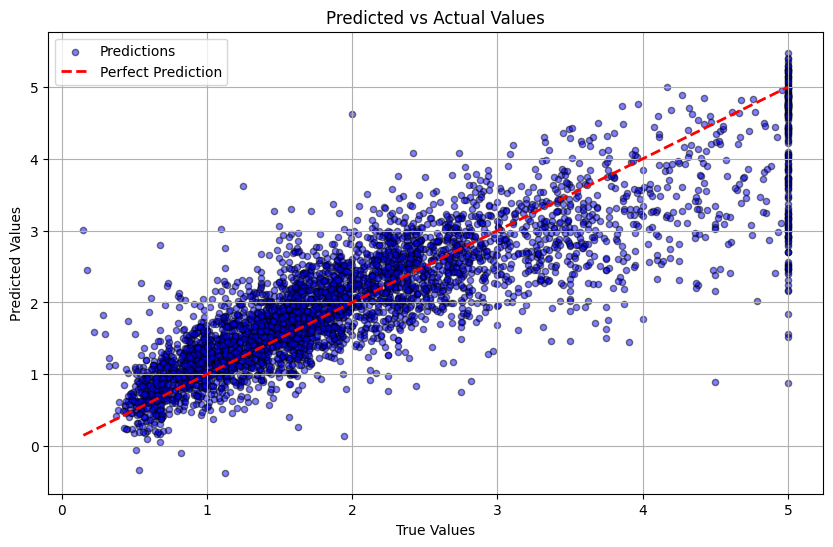

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(y_true, y_pred):
    """
    Plots the predicted vs actual values for California Housing predictions.
    
    Parameters:
    - y_true: Array of true target values (actual prices).
    - y_pred: Array of predicted target values from your SVR model.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, color='blue', alpha=0.5, edgecolor='k', s=20, label="Predictions")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2, label="Perfect Prediction")
    
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:
# Assuming y_test contains actual values and y_pred contains predictions from your model
plot_predictions(y_test_original_scale, y_pred_original_scale)
